
### Sampling - Our Health Prognostics Framework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Virtual Metrology Model (statistical features)

In [2]:
from sklearn.metrics import mean_squared_error
from scipy.stats import kurtosis, skew

In [10]:
# add the latest MRR column
def get_orig_data(dataset):
    
    train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0).reset_index(drop=True)
    test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0).reset_index(drop=True)

    short_sampled_orig = train_orig.iloc[316*2:, :].reset_index(drop=True)
    latest_mrr_sampled = train_orig.iloc[:-316*2, -1].rename('latest_mrr').reset_index(drop=True)
    addmrr_sampled_orig = pd.concat([short_sampled_orig, latest_mrr_sampled], axis=1)

    short_unsampled_orig = train_orig.iloc[316*1:, :].reset_index(drop=True)
    latest_mrr_unsampled = train_orig.iloc[:-316*1, -1].rename('latest_mrr').reset_index(drop=True)
    addmrr_unsampled_orig = pd.concat([short_unsampled_orig, latest_mrr_unsampled], axis=1)

    latest_mrr_test = pd.concat([train_orig.iloc[-316*1:, -1], test_orig.iloc[:-316*1, -1]], ignore_index=True).rename("latest_mrr").reset_index(drop=True)
    addmrr_test_orig = pd.concat([test_orig, latest_mrr_test], axis=1)
    
    return addmrr_sampled_orig, addmrr_unsampled_orig, addmrr_test_orig

# transfer into the input data
def get_stats_features(data):
    orig_X = data.iloc[:, :-2].to_numpy()
    orig_X = orig_X.reshape(-1, 316, orig_X.shape[1])
    orig_y = data.iloc[:, -2].tolist()
    data_y = [orig_y[i] for i in range(0, len(orig_y), 316)]
    # create the latest MRR for every samples
    latest_mrr = data.iloc[:, -1].tolist()
    latest_mrr = [latest_mrr[i] for i in range(0, len(latest_mrr), 316)]
    
    # calculate the statistics features
    means = np.mean(orig_X, axis=1)
    stds = np.std(orig_X, axis=1)
    medians = np.median(orig_X, axis=1)
    mins = np.min(orig_X, axis=1)
    maxs = np.max(orig_X, axis=1)
    kurts = kurtosis(orig_X, axis=1)
    skews = skew(orig_X, axis=1)
    stats_X = np.hstack([means, stds, medians, mins, maxs, kurts, skews])
    stats_X = np.nan_to_num(stats_X, nan=0.0)

    # add the latest MRR
    latest_mrr = np.array(latest_mrr).reshape(-1,1)
    data_X = np.concatenate((stats_X, latest_mrr), axis=1)

    return data_X, data_y

# fit different ML models
def fit_XGB(X_train, y_train):
    import xgboost as xgb
    params = {
        'objective': 'reg:squarederror',  # 回歸問題
        'max_depth': 3,                    # 樹的最大深度
        'learning_rate': 0.01,              # 學習率
        'n_estimators': 200                # 樹的數量
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    return model

def fit_RF(X_train, y_train):
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=2)
    model.fit(X_train, y_train)
    return model

def fit_KNN(X_train, y_train):
    from sklearn.neighbors import KNeighborsRegressor
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)
    return model

def fit_MLP(X_train, y_train):
    from sklearn.neural_network import MLPRegressor
    model = MLPRegressor(hidden_layer_sizes=(128, 16), activation='relu', solver='adam', max_iter=2000, random_state=2)
    model.fit(X_train, y_train)
    return model

# generate the VM MRR prediction
def get_VM_predition(dataset, mode_type):  # model_type: 'XGB'/'RF'/'KNN'/"MLP"
    
    addmrr_sampled_orig, addmrr_unsampled_orig, addmrr_test_orig = get_orig_data(dataset)
    
    # retain only sampled section for training
    sampled_train_orig = pd.concat([addmrr_sampled_orig.iloc[i:i+316] for i in range(0, len(addmrr_sampled_orig), 316*2)], ignore_index=True)
    unsampled_train_orig = pd.concat([addmrr_unsampled_orig.iloc[i:i+316] for i in range(316, len(addmrr_unsampled_orig), 316*2)], ignore_index=True)
    all_test_orig = pd.concat([unsampled_train_orig, addmrr_test_orig], ignore_index=True)
    extend_test_orig = pd.concat([addmrr_unsampled_orig.iloc[-316*4:], addmrr_test_orig], ignore_index=True)

    y_pred = {}
    X_train, y_train = get_stats_features(sampled_train_orig)
    # unsampled : unsampled wafer in training set / test : testing set / all : 'unsampled and test' / extend : 'testing set extended to past wafers'(for equipment state model)
    data_modes = {'unsampled':unsampled_train_orig, 'test':addmrr_test_orig, 'all':all_test_orig, 'extend':extend_test_orig}
    for mode, data in data_modes.items():
        match mode_type:
            case 'XGB':
                model = fit_XGB(X_train, y_train)
            case 'RF':
                model = fit_RF(X_train, y_train)
            case 'KNN':
                model = fit_KNN(X_train, y_train)
            case 'MLP':
                model = fit_MLP(X_train, y_train)

        X_test, y_test = get_stats_features(data)
        pred = model.predict(X_test)
        mse = mean_squared_error(y_test, pred)

        print('------------------------------------------------')
        print(mode)
        print(f"Statistical Features + {mode_type} VM test loss", round(mse, 3))
        y_pred[mode] = model.predict(X_test)

    return y_pred

#### Equipment State Model

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset

from util.env import get_device, set_device
from util.preprocess import build_loc_net, construct_data
from util.net_struct import get_feature_map, get_fc_graph_struc
from util.iostream import printsep

from datasets.TimeDataset_VM import TimeDataset

from models.GDN_GRU import GDN_GRU

from run.train import train
from run.test  import test
from run.evaluate import get_err_scores, get_best_performance_data, get_val_performance_data, get_full_err_scores

import sys
from datetime import datetime

import os
import argparse
from pathlib import Path

import json
import random

In [5]:
# check GPU situation
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

True
1
0
NVIDIA GeForce RTX 3090 Ti
11.8


In [6]:
# function to set random seed
def setup_seed(seed):
     random.seed(seed)
     np.random.seed(seed)
     if torch.cuda.is_available():
          torch.cuda.manual_seed(seed)
          torch.cuda.manual_seed_all(seed)
     torch.manual_seed(seed)
     torch.backends.cudnn.deterministic = True
     torch.backends.cudnn.benchmark = False

In [ ]:
class Main():
    def __init__(self, train_config, env_config, y_pred_train, y_pred_test, debug=False):

        self.train_config = train_config
        self.env_config = env_config
        self.datestr = None

        dataset = self.env_config['dataset']
        past_wafer = self.train_config['past_wafer']
        future_step = self.train_config['future_step']
        
        train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0)
        test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0)
        self.train_orig = train_orig
        self.test_orig = test_orig

        # concat the past wafer referenced from training set
        test_extend = pd.concat((train_orig.iloc[-(316 * (past_wafer + future_step - 1)):,:], test_orig), ignore_index=True)

        train_past = self.transfer_to_input(train_orig, past_wafer)
        test_extend_past = self.transfer_to_input(test_extend, past_wafer)

        train, test = train_past, test_extend_past

        if 'attack' in train.columns:
            train = train.drop(columns=['attack'])

        feature_map = get_feature_map(dataset)
        fc_struc = get_fc_graph_struc(dataset)

        set_device(env_config['device'])
        self.device = get_device()

        fc_edge_index = build_loc_net(fc_struc, list(train.columns), feature_map=feature_map)
        fc_edge_index = torch.tensor(fc_edge_index, dtype = torch.long)

        self.feature_map = feature_map

        train_dataset_indata = construct_data(train, feature_map, labels=train.MRR.tolist())
        test_dataset_indata = construct_data(test, feature_map, labels=test.MRR.tolist())

        cfg = {
            'wafer_len': train_config['wafer_len'],
            'past_wafer': train_config['past_wafer'],
            'future_step': train_config['future_step'],
        }

        train_dataset = TimeDataset(train_dataset_indata, fc_edge_index, y_pred_train, config=cfg, mode='train')
        test_dataset = TimeDataset(test_dataset_indata, fc_edge_index, y_pred_test, config=cfg, mode='test')


        train_dataloader, val_dataloader = self.get_loaders(train_dataset, train_config['seed'], train_config['batch'], val_ratio = train_config['val_ratio'])

        self.train_dataset = train_dataset
        self.test_dataset = test_dataset


        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = DataLoader(test_dataset, batch_size=train_config['batch'],
                            shuffle=False)


        edge_index_sets = []
        edge_index_sets.append(fc_edge_index)

        self.model = GDN_GRU(edge_index_sets, len(feature_map), 
                dim=train_config['dim'], 
                input_dim=train_config['wafer_len'],
                topk=train_config['topk'],
                past_wafer=train_config['past_wafer'],
                gru_inter_dim=train_config['gru_inter_dim'],
                gru_layer_num=train_config['gru_layer_num']
            ).to(self.device)

    def run(self):

        if len(self.env_config['load_model_path']) > 0:
            model_save_path = self.env_config['load_model_path']
        else:
            model_save_path = self.get_save_path()[0]

            self.train_log = train(self.model, model_save_path, 
                config = self.train_config,
                train_dataloader=self.train_dataloader,
                val_dataloader=self.val_dataloader, 
                feature_map=self.feature_map,
                test_dataloader=self.test_dataloader,
                test_dataset=self.test_dataset,
                train_dataset=self.train_dataset,
                dataset_name=self.env_config['dataset']
            )
        
        # test            
        self.model.load_state_dict(torch.load(model_save_path))
        best_model = self.model.to(self.device)

        test_loss, test_result = test(best_model, self.test_dataloader)
        val_loss, val_result = test(best_model, self.val_dataloader)

        return test_loss, val_loss, test_result, val_result

    # split out the validation set and transfer into dataloaders
    def get_loaders(self, train_dataset, seed, batch, val_ratio=0.1):
        
        dataset_len = int(len(train_dataset))
        train_use_len = int(dataset_len * (1 - val_ratio))
        val_use_len = int(dataset_len * val_ratio)
        val_start_index = random.randrange(train_use_len)
        indices = torch.arange(dataset_len)

        train_sub_indices = torch.cat([indices[:val_start_index], indices[val_start_index+val_use_len:]])
        train_subset = Subset(train_dataset, train_sub_indices)

        val_sub_indices = indices[val_start_index:val_start_index+val_use_len]
        val_subset = Subset(train_dataset, val_sub_indices)

        train_dataloader = DataLoader(train_subset, batch_size=batch,
                                shuffle=False)

        val_dataloader = DataLoader(val_subset, batch_size=batch,
                                shuffle=False)

        return train_dataloader, val_dataloader

    def get_save_path(self, feature_name=''):

        dir_path = self.env_config['save_path']
        
        if self.datestr is None:
            now = datetime.now()
            self.datestr = now.strftime('%m_%d-%H_%M_%S')
        datestr = self.datestr          

        paths = [
            f'./save_path/{dir_path}/best_{datestr}.pt',
            f'./results/{dir_path}/{datestr}.csv',
        ]

        for path in paths:
            dirname = os.path.dirname(path)
            Path(dirname).mkdir(parents=True, exist_ok=True)

        return paths
    
    # reshape the input data [316, 19 x 4]
    def transfer_to_input(self, orig_data, past_wafer=4): 
        
        if not (1 <= past_wafer <= 5): # 5 can be change to max quantity of past wafers
            raise ValueError("past_wafer must be between 1 and 5")

        oldest_wafer = orig_data.iloc[:, :-1]
        wafer_list = [oldest_wafer]

        # place the SVIDs of past wafers into the column dimension
        for i in range(2, past_wafer + 1):
            wafer_n = pd.DataFrame(np.zeros_like(oldest_wafer), columns=[f'{col}_{i}' for col in oldest_wafer.columns])
            wafer_n.iloc[:-316*(i-1)] = oldest_wafer.iloc[316*(i-1):].values
            wafer_list.append(wafer_n)

        mrr = orig_data.iloc[:, -1]
        wafer_list.append(mrr)

        input_data = pd.concat(wafer_list, axis=1)

        return input_data

A456

In [8]:
# training setting
batch=256
epoch=2000
wafer_len=316
past_wafer=4
dim=32
save_path_pattern='GDN_GRU'
dataset='A456'
device='cuda'
seed=2
comment=''
decay=0
val_ratio=0.2
topk=4
report='best'
load_model_path=''
future_step=1
gru_inter_dim=64
gru_layer_num=3

# set random seed
setup_seed(seed)

train_config = {
    'batch': batch,
    'epoch': epoch,
    'wafer_len': wafer_len,
    'dim': dim,
    'comment': comment,
    'seed': seed,
    'decay': decay,
    'val_ratio': val_ratio,
    'topk': topk,
    'past_wafer' : past_wafer,
    'future_step' : future_step,
    'gru_inter_dim' : gru_inter_dim,
    'gru_layer_num' : gru_layer_num
}

env_config={
    'save_path': save_path_pattern,
    'dataset': dataset,
    'report': report,
    'device': device,
    'load_model_path': load_model_path
}

In [11]:
# get VM MRR prediction
vm_pred = get_VM_predition(dataset,'RF')
y_pred_train = vm_pred['unsampled']
y_pred_test = vm_pred['extend']

------------------------------------------------
unsampled
Statistical Features + RF VM test loss 4.381
------------------------------------------------
test
Statistical Features + RF VM test loss 12.192
------------------------------------------------
all
Statistical Features + RF VM test loss 7.993
------------------------------------------------
extend
Statistical Features + RF VM test loss 12.179


In [12]:
# model training
main = Main(train_config, env_config, y_pred_train, y_pred_test, debug=False)
test_loss, _, value_result, _ = main.run()

epoch (1 / 2000) (Train_loss:4105.24731445, ACU_loss:8210.49462891, Val_loss:3892.15820312)
epoch (2 / 2000) (Train_loss:4011.54968262, ACU_loss:8023.09936523, Val_loss:3815.06494141)
epoch (3 / 2000) (Train_loss:3918.18896484, ACU_loss:7836.37792969, Val_loss:3734.71264648)
epoch (4 / 2000) (Train_loss:3825.23852539, ACU_loss:7650.47705078, Val_loss:3650.52856445)
epoch (5 / 2000) (Train_loss:3734.39306641, ACU_loss:7468.78613281, Val_loss:3562.62597656)
epoch (6 / 2000) (Train_loss:3647.03125000, ACU_loss:7294.06250000, Val_loss:3471.94848633)
epoch (7 / 2000) (Train_loss:3562.95227051, ACU_loss:7125.90454102, Val_loss:3383.02758789)
epoch (8 / 2000) (Train_loss:3482.57324219, ACU_loss:6965.14648438, Val_loss:3299.49780273)
epoch (9 / 2000) (Train_loss:3405.60168457, ACU_loss:6811.20336914, Val_loss:3222.25000000)
epoch (10 / 2000) (Train_loss:3331.39062500, ACU_loss:6662.78125000, Val_loss:3149.65551758)
epoch (11 / 2000) (Train_loss:3259.28649902, ACU_loss:6518.57299805, Val_loss:3

MSE :  8.813


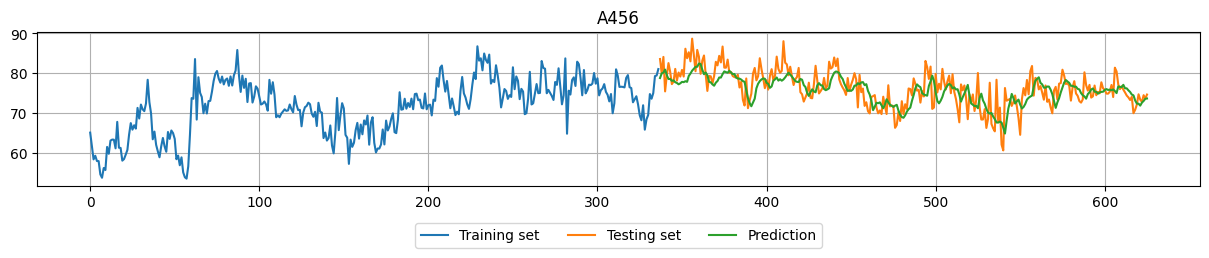

In [12]:
print('MSE : ', round(test_loss, 3))

# plot the result
y_train = [main.train_orig['MRR'][i] for i in range(0, len(main.train_orig), 316)]  
y_train = [y_train[i] for i in range(len(y_train)) if i % 2 == 0]
y_pred = np.array(value_result[0]).flatten()
y_truth = np.array(value_result[1])[:, 0].tolist()

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(len(y_train)), y_train, label='Train')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_truth, label='Test')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(['Training set', 'Testing set', 'Prediction'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.45))
plt.grid(True)
plt.show()

B456

In [ ]:
# training setting
batch=256
epoch=2000
wafer_len=316
past_wafer=4
dim=32
save_path_pattern='GDN_GRU'
dataset='B456'
device='cuda'
seed=2
comment=''
decay=0
val_ratio=0.2
topk=4
report='best'
load_model_path=''
future_step=1
gru_inter_dim=8
gru_layer_num=2

# set random seed
setup_seed(seed)

train_config = {
    'batch': batch,
    'epoch': epoch,
    'wafer_len': wafer_len,
    'dim': dim,
    'comment': comment,
    'seed': seed,
    'decay': decay,
    'val_ratio': val_ratio,
    'topk': topk,
    'past_wafer' : past_wafer,
    'future_step' : future_step,
    'gru_inter_dim' : gru_inter_dim,
    'gru_layer_num' : gru_layer_num
}

env_config={
    'save_path': save_path_pattern,
    'dataset': dataset,
    'report': report,
    'device': device,
    'load_model_path': load_model_path
}

In [11]:
# get VM MRR prediction
vm_pred = get_VM_predition(dataset,'RF')
y_pred_train = vm_pred['unsampled']
y_pred_test = vm_pred['extend']

------------------------------------------------
unsampled
pretain GDN-RF VM test loss 5.976
------------------------------------------------
test
pretain GDN-RF VM test loss 17.214
------------------------------------------------
all
pretain GDN-RF VM test loss 11.18
------------------------------------------------
extend
pretain GDN-RF VM test loss 17.186


In [11]:
# model training
main = Main(train_config, env_config, y_pred_train, y_pred_test, debug=False)
test_loss, _, value_result, _ = main.run()

epoch (1 / 2000) (Train_loss:4737.27563477, ACU_loss:9474.55126953, Val_loss:4465.80712891)
epoch (2 / 2000) (Train_loss:4629.93334961, ACU_loss:9259.86669922, Val_loss:4377.77197266)
epoch (3 / 2000) (Train_loss:4523.08886719, ACU_loss:9046.17773438, Val_loss:4286.92480469)
epoch (4 / 2000) (Train_loss:4417.01245117, ACU_loss:8834.02490234, Val_loss:4192.35302734)
epoch (5 / 2000) (Train_loss:4313.25659180, ACU_loss:8626.51318359, Val_loss:4093.69116211)
epoch (6 / 2000) (Train_loss:4213.23315430, ACU_loss:8426.46630859, Val_loss:3991.65673828)
epoch (7 / 2000) (Train_loss:4117.34387207, ACU_loss:8234.68774414, Val_loss:3890.15576172)
epoch (8 / 2000) (Train_loss:4025.45385742, ACU_loss:8050.90771484, Val_loss:3794.06640625)
epoch (9 / 2000) (Train_loss:3937.30102539, ACU_loss:7874.60205078, Val_loss:3705.43310547)
epoch (10 / 2000) (Train_loss:3852.09289551, ACU_loss:7704.18579102, Val_loss:3622.50219727)
epoch (11 / 2000) (Train_loss:3769.13598633, ACU_loss:7538.27197266, Val_loss:3

MSE :  15.961


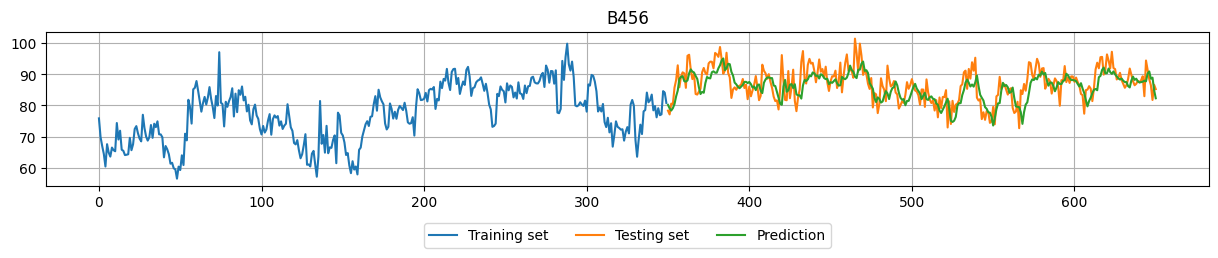

In [ ]:
print('MSE : ', round(test_loss, 3))

# plot the result
y_train = [main.train_orig['MRR'][i] for i in range(0, len(main.train_orig), 316)]  
y_train = [y_train[i] for i in range(len(y_train)) if i % 2 == 0]
y_pred = np.array(value_result[0]).flatten()
y_truth = np.array(value_result[1])[:, 0].tolist()

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(len(y_train)), y_train, label='Train')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_truth, label='Test')
plt.plot(range(len(y_train), len(y_train) + len(y_truth)), y_pred, label='pred')
plt.title(dataset)
plt.legend(['Training set', 'Testing set', 'Prediction'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.45))
plt.grid(True)
plt.show()

#### Graph Explanability

In [15]:
import seaborn as sns
def graph_heatmap(adj_mat, cmap='coolwarm', value_range=[None, None], cbar=False): 
    
    wide = 20 if cbar else 16
    f, ax = plt.subplots(figsize=(wide, 16))
    mask = adj_mat == 0
    sns.heatmap(adj_mat, annot=False, linewidths=.5, ax=ax, mask=mask, cmap=cmap,
                vmin=value_range[0], vmax=value_range[1], linecolor='lightgray',
                cbar=cbar, cbar_kws={"shrink": 0.5})
        
    # add horizontal and vertical lines
    num_divisions = 4  # divide each side into 4 sections (past wafers)
    step = adj_mat.shape[0] / num_divisions  # calculate the size of each section
    
    for i in range(1, num_divisions):  # add boundary lines at 1/2/3
        plt.axhline(i * step, color='gray', linewidth=1)
        plt.axvline(i * step, color='gray', linewidth=1)

    # set wafer labels (top and right side)
    wafer_labels = ['Wafer1', 'Wafer2', 'Wafer3', 'Wafer4']
    ax.set_xticks(np.linspace(0, adj_mat.shape[0], num_divisions + 1)[:-1] + step / 2)
    ax.set_yticks(np.linspace(0, adj_mat.shape[0], num_divisions + 1)[:-1] + step / 2)

    # add top labels
    ax2 = ax.secondary_xaxis('top')
    ax2.set_xticks(np.linspace(0, adj_mat.shape[0], num_divisions + 1)[:-1] + step / 2)
    ax2.set_xticklabels(wafer_labels, fontsize=12)

    # add right-side labels
    ax3 = ax.secondary_yaxis('right')
    ax3.set_yticks(np.linspace(0, adj_mat.shape[0], num_divisions + 1)[:-1] + step / 2)
    ax3.set_yticklabels(wafer_labels, fontsize=12)

    # keep the bottom-left labels
    ax.set_xticks(np.arange(0.5, adj_mat.shape[0] + 0.5))
    ax.set_yticks(np.arange(0.5, adj_mat.shape[0] + 0.5))
    ax.set_xticklabels(np.arange(1, adj_mat.shape[0] + 1), fontsize=10)
    ax.set_yticklabels(np.arange(1, adj_mat.shape[0] + 1), fontsize=10)

    # adjust the colorbar position
    if cbar:
        cbar = ax.collections[0].colorbar
        cbar.ax.set_position([0.8, 0.15, 0.02, 0.7])  # (x, y, width, height)

    plt.show()

In [16]:
# calculate the average weight matrix of all samples
def compute_graph(model: nn.Module, X: TimeDataset):

    n_samples, feature_num, slide_win = X.x.shape

    # do the forward pass
    data, org_edge_index, pastmrr = X.x.float().to('cuda'), X.edge_index.float().to('cuda'), X.z.float().to('cuda')
    with torch.no_grad():
        model(data, org_edge_index, pastmrr)

    coeff_weights = model.GDN_layer.gnn_layers[0].att_weight_1.cpu().detach().numpy()
    edge_index = model.GDN_layer.gnn_layers[0].edge_index_1.cpu().detach().numpy()
    weight_mat = np.zeros((feature_num, feature_num))
    count_mat = np.zeros((feature_num, feature_num))

    for i in range(len(coeff_weights)):
        edge_i, edge_j = edge_index[:, i]
        edge_i, edge_j = edge_i % feature_num, edge_j % feature_num
        weight_mat[edge_i][edge_j] += coeff_weights[i]
        count_mat[edge_i][edge_j] += 1

    weight_mat /= count_mat

    return weight_mat

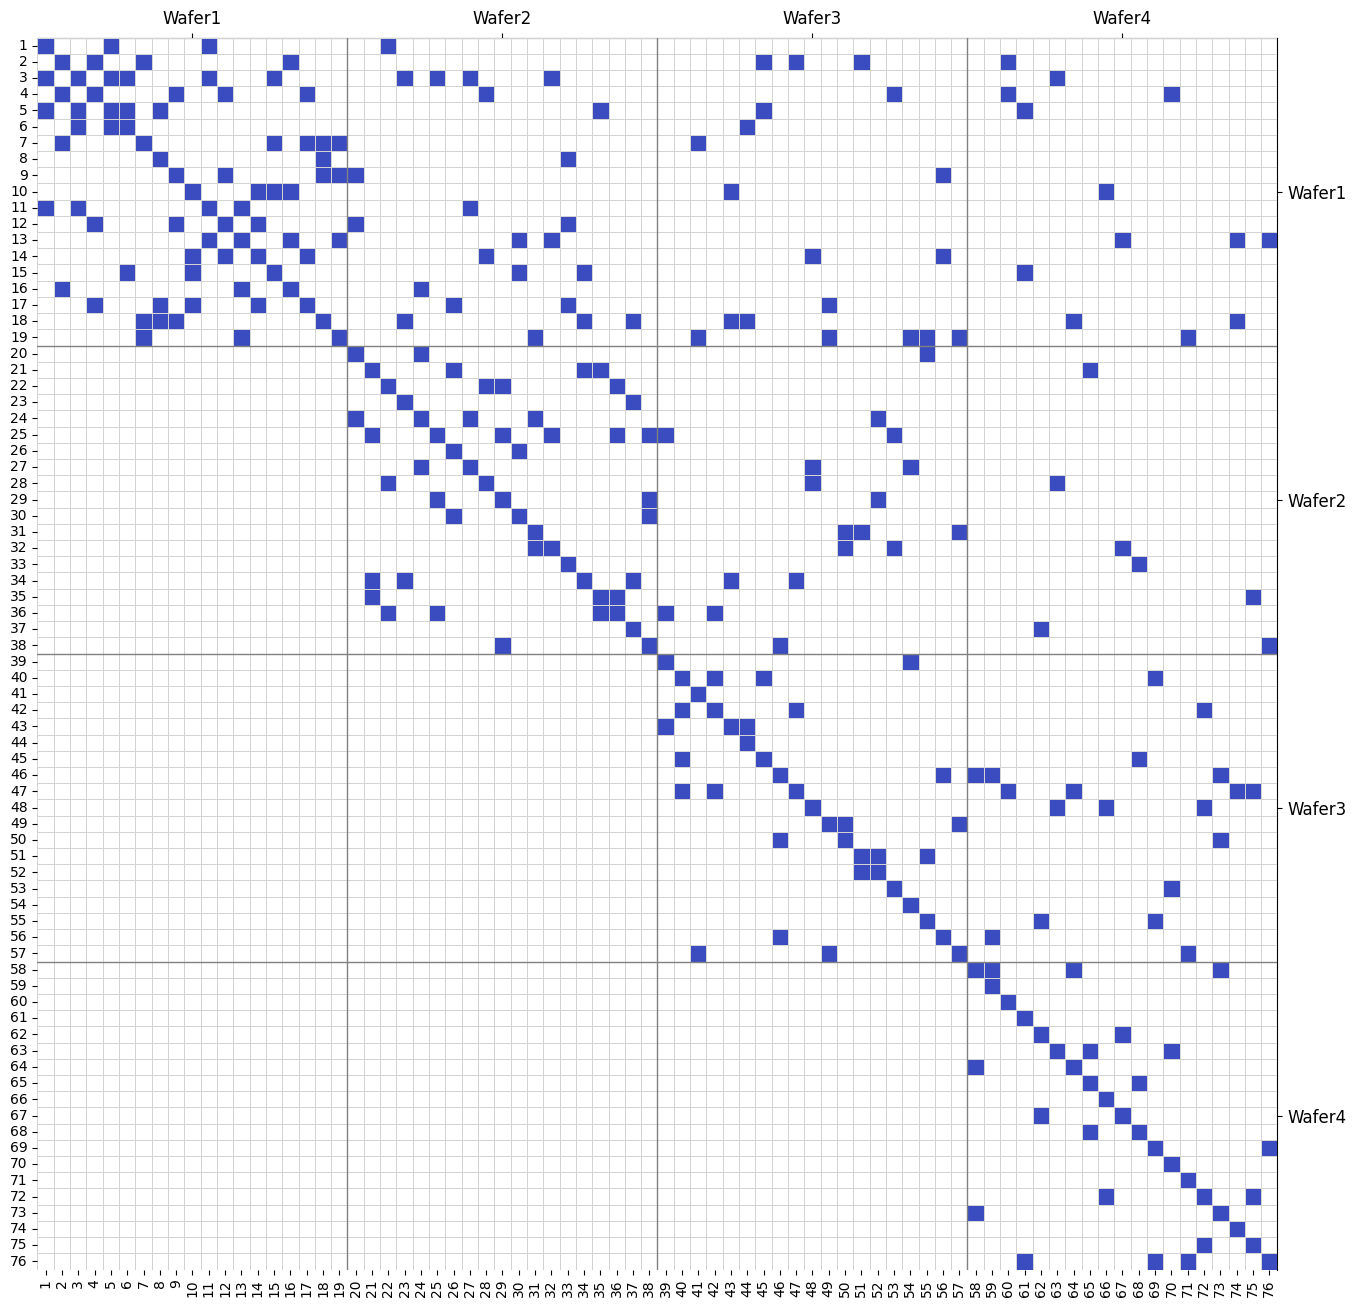

In [17]:
# plot the adjacent matrix
adj_mat = compute_graph(main.model, main.train_dataset)
adj_mat = ~np.isnan(adj_mat)
graph_heatmap(adj_mat)

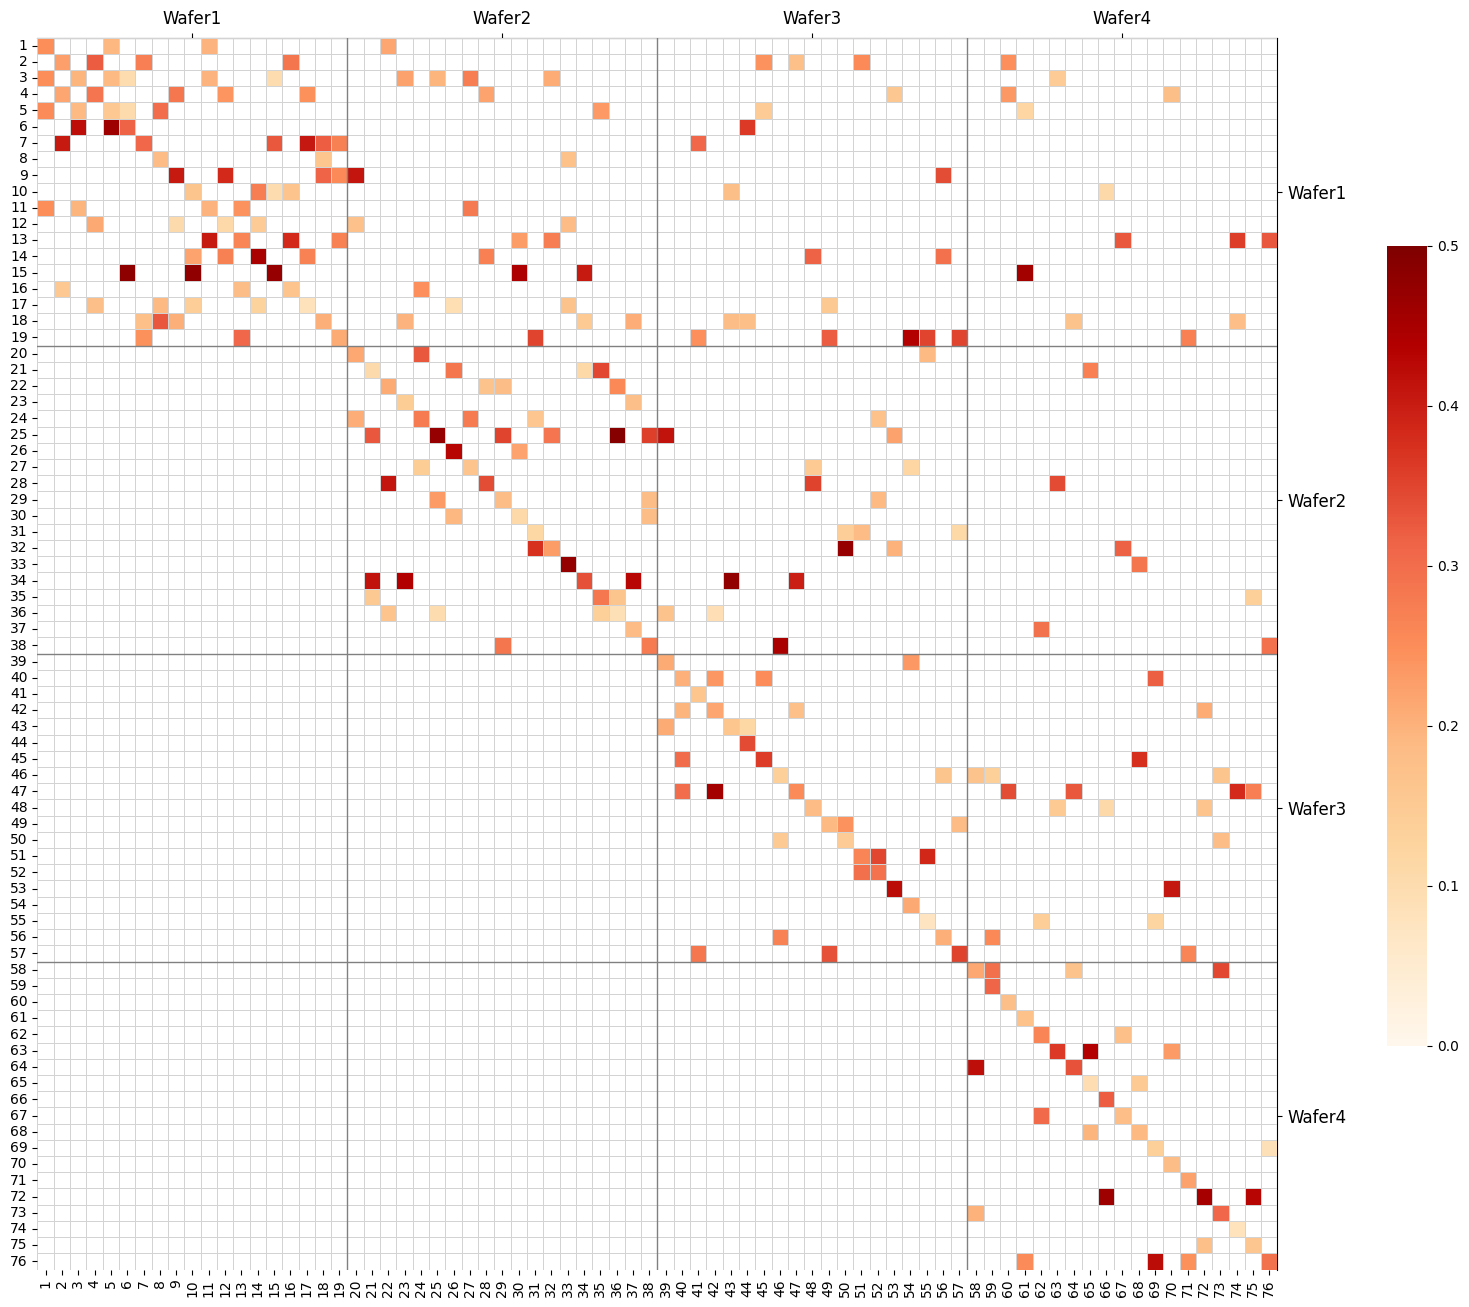

In [19]:
# plot the attention weight matrix
weight_mat = compute_graph(main.model, main.train_dataset)
graph_heatmap(weight_mat, cmap='OrRd', value_range=[0, 0.5], cbar=True)

In [ ]:
# calculate the column and row mean
weight_mat[weight_mat == 0] = np.nan

col_means = [np.nanmean(weight_mat[:, i*19:(i+1)*19]) for i in range(4)]
col_means = np.round(col_means, 4)

row_means = [np.nanmean(weight_mat[i*19:(i+1)*19, :]) for i in range(4)]
row_means = np.round(row_means, 4)

mean_tb = pd.DataFrame({'Wafer':[1, 2, 3, 4], 'Column':col_means, 'Row':row_means})
print(mean_tb)

   Wafer  Column     Row
0      1    0.25  0.2496
1      2    0.25  0.2547
2      3    0.25  0.2415
3      4    0.25  0.2551


In [20]:
# calculation the variance of the attention weights
def compute_graph_var(model: nn.Module, X: TimeDataset):

    n_samples, feature_num, slide_win = X.x.shape

    # Do a forward pass in the model
    data, org_edge_index, pastmrr = X.x.float().to('cuda'), X.edge_index.float().to('cuda'), X.z.float().to('cuda')
    with torch.no_grad():
        model(data, org_edge_index, pastmrr)

    coeff_weights = model.GDN_layer.gnn_layers[0].att_weight_1.cpu().detach().numpy()
    edge_index = model.GDN_layer.gnn_layers[0].edge_index_1.cpu().detach().numpy()
    
    weight_mat = np.zeros((feature_num, feature_num))
    count_mat = np.zeros((feature_num, feature_num))
    sum_sq_mat = np.zeros((feature_num, feature_num))  # 用來存每個位置權重的平方和

    for i in range(len(coeff_weights)):
        edge_i, edge_j = edge_index[:, i]
        edge_i, edge_j = edge_i % feature_num, edge_j % feature_num
        weight_mat[edge_i][edge_j] += coeff_weights[i]
        sum_sq_mat[edge_i][edge_j] += coeff_weights[i] ** 2  # 累積平方
        count_mat[edge_i][edge_j] += 1

    weight_mat /= count_mat  # 計算平均邊權重

    # 計算變異數矩陣 var_mat: (平方的平均) - (平均的平方)
    var_mat = (sum_sq_mat / count_mat) - (weight_mat ** 2)
    var_mat = np.nan_to_num(var_mat, nan=0)

    return var_mat

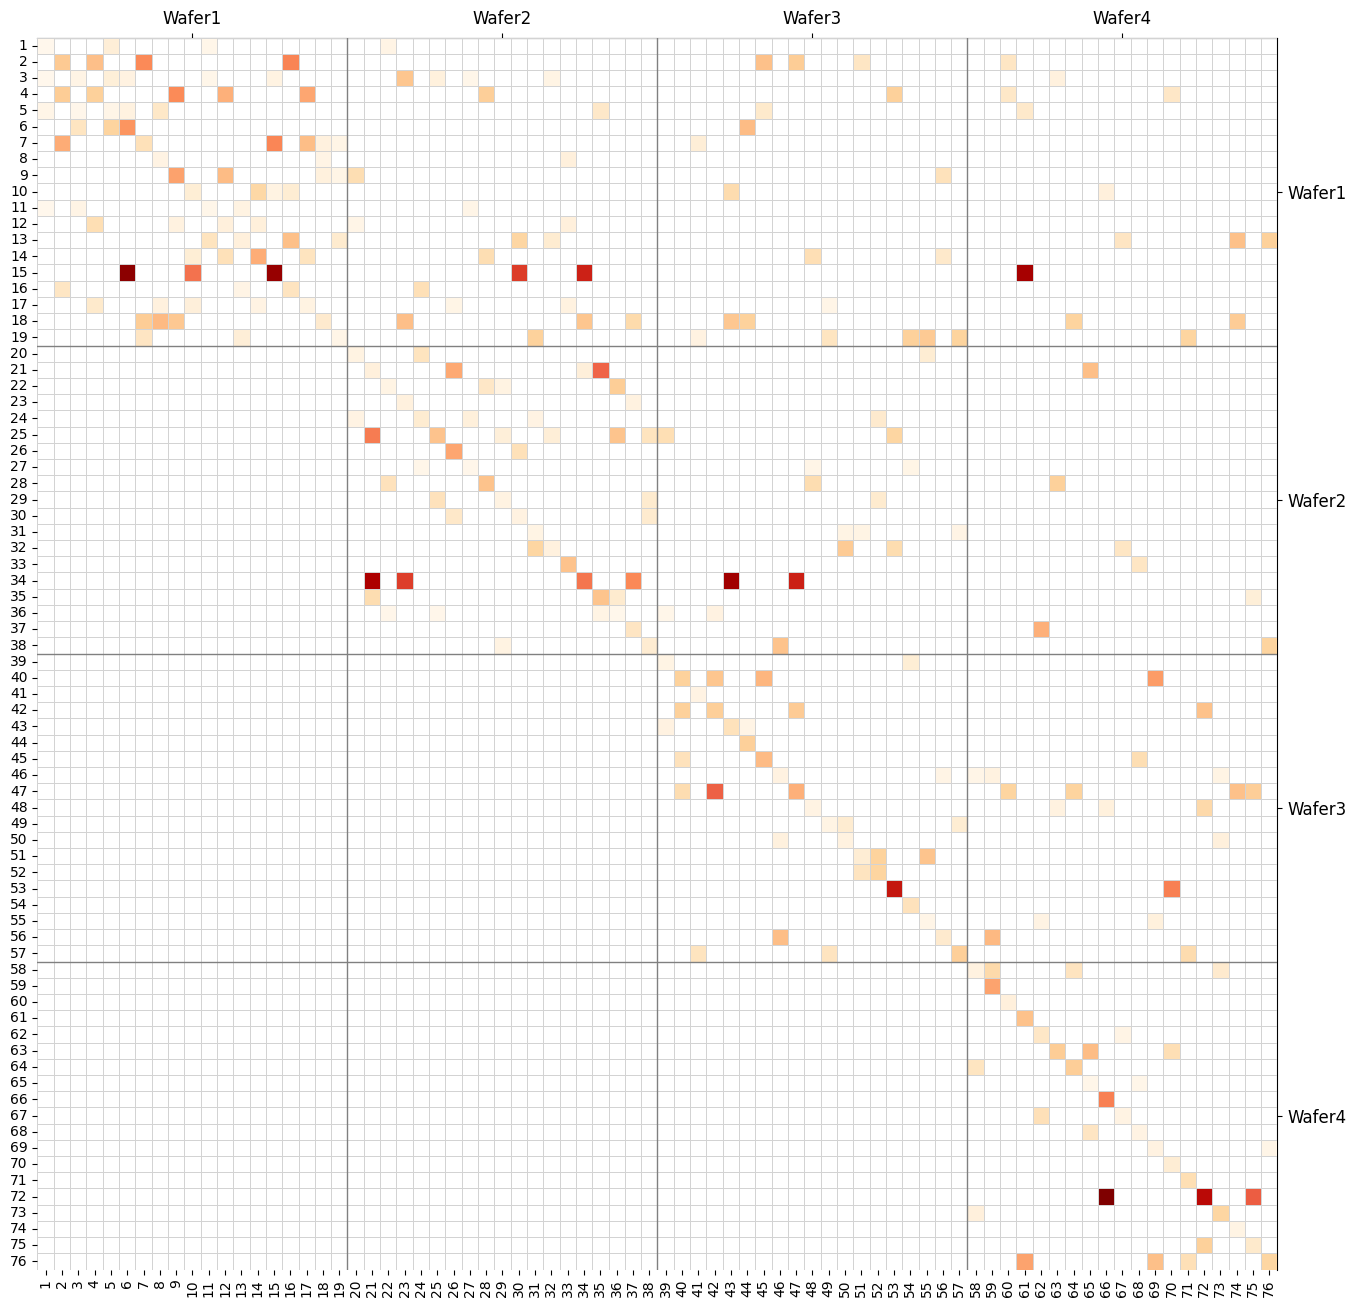

In [21]:
# plot the variance matrix
var_mat = compute_graph_var(main.model, main.train_dataset)
graph_heatmap(var_mat, 'OrRd')

In [ ]:
# calculate the column and row mean
var_mat[var_mat == 0] = np.nan

col_means = [np.nanmean(var_mat[:, i*19:(i+1)*19]) for i in range(4)]
col_means = np.round(col_means, 4)

row_means = [np.nanmean(var_mat[i*19:(i+1)*19, :]) for i in range(4)]
row_means = np.round(row_means, 4)

mean_tb = pd.DataFrame({'Wafer':[1, 2, 3, 4], 'Column':col_means, 'Row':row_means})
print(mean_tb)

   Wafer  Column     Row
0      1  0.0298  0.0311
1      2  0.0300  0.0309
2      3  0.0319  0.0316
3      4  0.0354  0.0364


In [22]:
# calculation the correlation between weights and MRR prediction
from scipy.stats import pearsonr
def compute_graph_corr(model:nn.Module, X:TimeDataset, pred:list=[]):
    n_samples, feature_num, slide_win = X.x.shape

    # do the forward pass
    data, org_edge_index, pastmrr = X.x.float().to('cuda'), X.edge_index.float().to('cuda'), X.z.float().to('cuda')
    with torch.no_grad():
        model(data, org_edge_index, pastmrr)

    coeff_weights = model.GDN_layer.gnn_layers[0].att_weight_1.cpu().detach().numpy()
    edge_index = model.GDN_layer.gnn_layers[0].edge_index_1.cpu().detach().numpy()

    if len(pred) == 0:
        y = X.y.cpu().numpy().flatten()
    else:
        y = pred
    
    # initialize a dictionary to store weights for each position
    weights_dict = {}

    # accumulate weights
    for i in range(len(coeff_weights)):
        edge_i, edge_j = edge_index[:, i]
        edge_i, edge_j = edge_i % feature_num, edge_j % feature_num
        
        if (edge_i, edge_j) not in weights_dict:
            weights_dict[(edge_i, edge_j)] = []
        weights_dict[(edge_i, edge_j)].append(coeff_weights[i])

    # initialize the correlation matrix
    corr_mat = np.zeros((feature_num, feature_num))

    # Compute correlation for each position
    for (i, j), weights in weights_dict.items():
        if len(weights) > 1:  # need at least 2 points to calculate correlation
            weights = np.array(weights).flatten().tolist()  # ensure weights is a 1D array
            correlation, _ = pearsonr(weights, y)  # y should be aligned with the weights
            corr_mat[i][j] = correlation

    return corr_mat

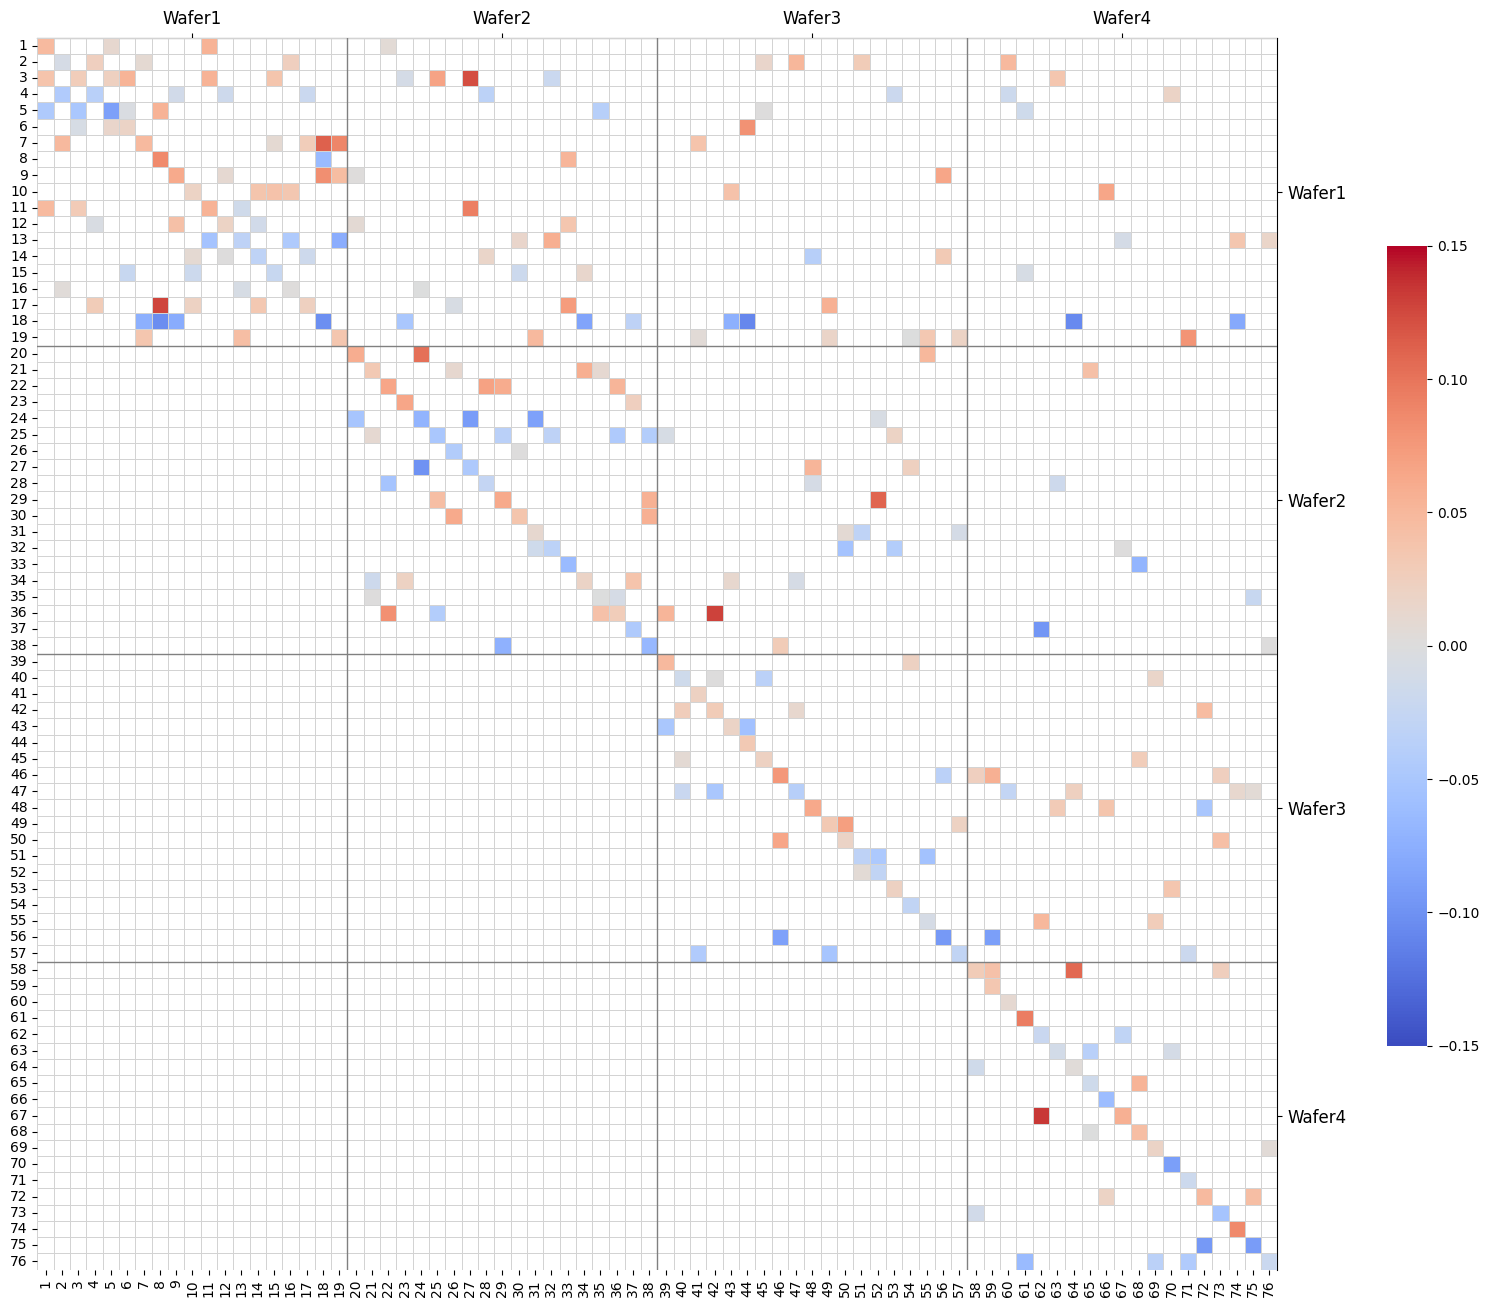

In [25]:
# plot the correlation matrix
corr_mat = compute_graph_corr(main.model, main.test_dataset, y_pred)
graph_heatmap(corr_mat, value_range=[-0.15, 0.15], cbar=True)

In [ ]:
# calculate column and row sum of square mean
corr_mat[corr_mat == 0] = np.nan

col_means = [np.nanmean(np.square(corr_mat[:, i*19:(i+1)*19])) for i in range(4)]
col_means = np.round(col_means, 4)

row_means = [np.nanmean(np.square(corr_mat[:, i*19:(i+1)*19])) for i in range(4)]
row_means = np.round(row_means, 4)

mean_tb = pd.DataFrame({'Wafer':[1, 2, 3, 4], 'Column':col_means, 'Row':row_means})
print(mean_tb)

   Wafer  Column     Row
0      1  0.0023  0.0023
1      2  0.0026  0.0026
2      3  0.0021  0.0021
3      4  0.0024  0.0024
